In [2]:
import sys
import os
import json
import signal

src_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(src_directory)

from llm_handler import *
from evaluate import *

In [3]:
def load_test_contracts(test_data_dir):
    json_dir = os.path.join(test_data_dir, "json")
    text_dir = os.path.join(test_data_dir, "text")

    test_contracts = {}

    for sub_folder in os.listdir(json_dir):
        json_sub_folder = os.path.join(json_dir, sub_folder)
        text_sub_folder = os.path.join(text_dir, sub_folder)
        
        if os.path.isdir(json_sub_folder) and os.path.isdir(text_sub_folder):
            contracts = []
            for json_file in os.listdir(json_sub_folder):
                if json_file.endswith(".json"):
                    text_file = json_file.replace(".json", ".txt")
                    json_path = os.path.join(json_sub_folder, json_file)
                    text_path = os.path.join(text_sub_folder, text_file)
                    
                    if os.path.exists(json_path) and os.path.exists(text_path):
                        with open(json_path, 'r') as jf:
                            json_content = json.load(jf)
                        
                        with open(text_path, 'r') as tf:
                            text_content = tf.read()
                        
                        contracts.append({
                            "id": json_file,
                            "cdm": json_content,
                            "description": text_content
                        })
            
            if contracts:
                test_contracts[sub_folder] = contracts

    return test_contracts

In [4]:
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def get_coverage_with_timeout(llm_handler, description, cdm, TIMEOUT_SECONDS):
    """Runs get_coverage_score() with a timeout. If it exceeds the limit, returns None."""
    
    # Set up the timeout signal
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(TIMEOUT_SECONDS)  # Start the timeout
    
    try:
        result = get_coverage_score(get_coverage(llm_handler, description, cdm))
        if result['score'] == 'undefined':
            return None
        signal.alarm(0)  # Cancel the alarm if successful
        return result
    except TimeoutException:
        return None



def generate_eval_results(llm_handler, test_contracts, generated_cdm_parent_folder, generated_cdm_folder, TIMEOUT_SECONDS = 900):

    for contract_type, contracts in test_contracts.items():
        print("\n\n")
        print("=" * 60)
        print(f"Evaluating contracts of type: {contract_type}")
        print("=" * 60)

        for contract in contracts:
            print("\nEvaluating " + contract['id'] + "...")
            print("-" * 80)

            without_rag_path = os.path.join(generated_cdm_parent_folder, generated_cdm_folder, "without_rag", contract_type, contract['id'])
            with_rag_path = os.path.join(generated_cdm_parent_folder, generated_cdm_folder, "with_rag", contract_type, contract['id'])

            eval_without_rag_path = without_rag_path.replace("test_results_cdm", "evaluation_results_cdm")
            eval_with_rag_path = with_rag_path.replace("test_results_cdm", "evaluation_results_cdm")

            os.makedirs(os.path.dirname(eval_without_rag_path), exist_ok=True)
            os.makedirs(os.path.dirname(eval_with_rag_path), exist_ok=True)

            cdm, cdm_rag = {}, {}

            if os.path.exists(without_rag_path):
                with open(without_rag_path) as f:
                    cdm = json.load(f)
            else:
                print("!!! CDM does not exist: " + without_rag_path)

            if os.path.exists(with_rag_path):
                with open(with_rag_path) as f:
                    cdm_rag = json.load(f)
            else:
                print("!!! CDM_RAG does not exist: " + with_rag_path)

            if not os.path.exists(eval_without_rag_path):
                semantic_coverage = get_coverage_with_timeout(llm_handler, contract['description'], cdm, TIMEOUT_SECONDS)
                if semantic_coverage is not None:
                    print("Without RAG : ", semantic_coverage)
                    with open(eval_without_rag_path, "w") as f:
                        json.dump(semantic_coverage, f, indent=4)
                else:
                    print("!!!Skipping Without RAG evaluation due to timeout.")
            else:
                print("Without RAG : Results already generated!")

            if not os.path.exists(eval_with_rag_path):
                rag_semantic_coverage = get_coverage_with_timeout(llm_handler, contract['description'], cdm_rag, TIMEOUT_SECONDS)
                if rag_semantic_coverage is not None:
                    print("With RAG    : ", rag_semantic_coverage)
                    with open(eval_with_rag_path, "w") as f:
                        json.dump(rag_semantic_coverage, f, indent=4)
                else:
                    print("!!!Skipping With RAG evaluation due to timeout.")
            else:
                print("With RAG : Results already generated!")

In [5]:
test_data_dir = "../../data/type_wise_cdm_samples/test_data"

test_contracts = load_test_contracts(test_data_dir)

llm_handler = LLMHandler(
        model_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
        token="huggingface access token",
        temperature=0.2
    )

generated_cdm_folder = "Meta-Llama-3.1-8B-Instruct"

TIMEOUT_SECONDS = 300


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]
Device set to use cuda:0


Initialized LLM with model: meta-llama/Meta-Llama-3.1-8B-Instruct


In [6]:
# generated_cdm_parent_folder = "template_population/test_results_cdm"
# generate_eval_results(llm_handler, test_contracts, generated_cdm_parent_folder, generated_cdm_folder, TIMEOUT_SECONDS)

In [7]:
import statistics
import os
import json

def compute_summary_stats(test_data_dir, generated_cdm_parent_folder, generated_cdm_folder):
    
    test_contracts = load_test_contracts(test_data_dir)

    scores, scores_rag = {}, {}
    all_scores, all_scores_rag = [], []

    for contract_type, contracts in test_contracts.items():
        scores[contract_type], scores_rag[contract_type] = [], []
        
        for contract in contracts:
            for mode, store in [("without_rag", scores[contract_type]), ("with_rag", scores_rag[contract_type])]:
                path = os.path.join(generated_cdm_parent_folder, generated_cdm_folder, mode, contract_type, contract['id'])
                
                if os.path.exists(path):
                    with open(path) as f:
                        curr_scores = json.load(f)['score']
                        store.append(curr_scores)
                        if mode == "without_rag":
                            all_scores.append(curr_scores)
                        else:
                            all_scores_rag.append(curr_scores)
                else:
                    print(f"!!! ({mode.upper()}) eval results do not exist: {path}")

    # Compute statistics for each contract type
    def compute_stats(data):
        return {
            "min": min(data) if data else None,
            "max": max(data) if data else None,
            "mean": sum(data) / len(data) if data else None,
            "median": statistics.median(data) if data else None,
            "sd": statistics.stdev(data) if len(data) > 1 else 0  # Avoid error when len(data) < 2
        } if data else {}

    contract_type_stats = {key: compute_stats(values) for key, values in scores.items()}
    contract_type_stats_rag = {key: compute_stats(values) for key, values in scores_rag.items()}

    # Compute overall statistics for all contract types combined
    contract_type_stats["AllTypesCombined"] = compute_stats(all_scores)
    contract_type_stats_rag["AllTypesCombined"] = compute_stats(all_scores_rag)

    return contract_type_stats, contract_type_stats_rag


In [8]:
generated_cdm_parent_folder = "template_population/evaluation_results_cdm"
summary_stats, summary_stats_rag = compute_summary_stats(test_data_dir, generated_cdm_parent_folder, generated_cdm_folder)

print(summary_stats)
print(summary_stats_rag)

{'EquitySwap': {'min': 81.6326530612245, 'max': 95.38461538461539, 'mean': 88.55197795152333, 'median': 89.14728682170542, 'sd': 5.397424205810367}, 'InterestRate': {'min': 75.84269662921348, 'max': 100.0, 'mean': 90.0323401345254, 'median': 94.5945945945946, 'sd': 11.47956956918658}, 'Commodity': {'min': 82.7250608272506, 'max': 97.90209790209789, 'mean': 89.8470832287152, 'median': 90.9090909090909, 'sd': 6.285798051284467}, 'CreditDefaultSwap': {'min': 83.98950131233596, 'max': 97.74436090225564, 'mean': 89.51086124490723, 'median': 86.8596881959911, 'sd': 5.709870332221426}, 'ForeignExchange': {'min': 84.11214953271028, 'max': 93.40659340659342, 'mean': 89.5466930682027, 'median': 90.3225806451613, 'sd': 3.435437236488727}, 'EquityOption': {'min': 82.52427184466019, 'max': 94.97206703910615, 'mean': 88.88885557926277, 'median': 88.3977900552486, 'sd': 5.686654539207488}, 'AllTypesCombined': {'min': 75.84269662921348, 'max': 100.0, 'mean': 89.39630186785612, 'median': 89.73493373343

In [9]:
generated_cdm_parent_folder = "direct_cdm_generation/evaluation_results_cdm"
summary_stats_2, summary_stats_rag_2 = compute_summary_stats(test_data_dir, generated_cdm_parent_folder, generated_cdm_folder)

print(summary_stats_2)
print(summary_stats_rag_2)

{'EquitySwap': {'min': 74.07407407407408, 'max': 96.60574412532638, 'mean': 86.53508394759432, 'median': 89.10891089108911, 'sd': 9.619131791445563}, 'InterestRate': {'min': 67.85714285714286, 'max': 92.1985815602837, 'mean': 80.06307921333581, 'median': 82.3529411764706, 'sd': 10.790787595014189}, 'Commodity': {'min': 71.91780821917808, 'max': 100.0, 'mean': 85.97713314156047, 'median': 83.33333333333333, 'sd': 11.73017198687633}, 'CreditDefaultSwap': {'min': 67.66917293233084, 'max': 98.0392156862745, 'mean': 89.50983473515461, 'median': 94.66019417475728, 'sd': 12.533627881737328}, 'ForeignExchange': {'min': 79.84790874524715, 'max': 96.38554216867469, 'mean': 91.00240866905618, 'median': 93.02325581395348, 'sd': 6.626862870510212}, 'EquityOption': {'min': 67.34006734006734, 'max': 97.5609756097561, 'mean': 85.09993839043571, 'median': 88.73720136518772, 'sd': 11.275065290399024}, 'AllTypesCombined': {'min': 67.34006734006734, 'max': 100.0, 'mean': 86.36457968285619, 'median': 89.22

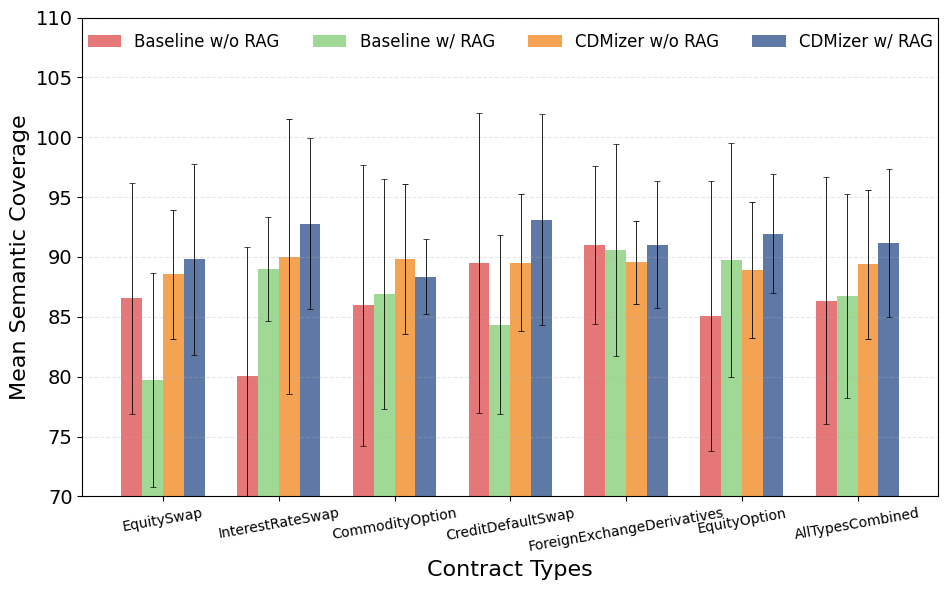

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Keep your original colors
# colors = ["#E15759", "#76B7B2", "#F28E2B", "#4E79A7"]
colors = ["#E46869", "#96D58A", "#F39940", "#4E6B9C"]


contract_types = list(summary_stats.keys())

display_labels = {
    "InterestRate": "InterestRateSwap",
    "Commodity": "CommodityOption",
    "ForeignExchange": "ForeignExchangeDerivatives"
}

xtick_labels = [display_labels.get(c, c) for c in contract_types]

# Extract means
means_summary = [summary_stats[c]['mean'] for c in contract_types]
means_summary_rag = [summary_stats_rag[c]['mean'] for c in contract_types]
means_summary_2 = [summary_stats_2[c]['mean'] for c in contract_types]
means_summary_rag_2 = [summary_stats_rag_2[c]['mean'] for c in contract_types]

# Extract standard deviations (SD)
sd_summary = [summary_stats[c]['sd'] for c in contract_types]
sd_summary_rag = [summary_stats_rag[c]['sd'] for c in contract_types]
sd_summary_2 = [summary_stats_2[c]['sd'] for c in contract_types]
sd_summary_rag_2 = [summary_stats_rag_2[c]['sd'] for c in contract_types]

x = np.arange(len(contract_types))
width = 0.18

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with SD error bars (matching colors, subtle caps)
ax.bar(x - 1.5*width, means_summary_2, width, yerr=sd_summary_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/o RAG", color=colors[0], alpha=0.9)
ax.bar(x - 0.5*width, means_summary_rag_2, width, yerr=sd_summary_rag_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/ RAG", color=colors[1], alpha=0.9)
ax.bar(x + 0.5*width, means_summary, width, yerr=sd_summary, capsize=2, error_kw=dict(lw=0.6, capthick=0.6), label="CDMizer w/o RAG", color=colors[2], alpha=0.9)
ax.bar(x + 1.5*width, means_summary_rag, width, yerr=sd_summary_rag, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="CDMizer w/ RAG", color=colors[3], alpha=0.9)

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=10, fontsize=10)

# Labels & Formatting (unchanged from your original)
ax.set_ylabel("Mean Semantic Coverage", fontsize=16)
ax.set_xlabel("Contract Types", fontsize=16)
ax.set_ylim(70, 110)
ax.tick_params(axis="y", labelsize=14)

# Legend (exact same position & format as yours)
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=4, fontsize=12, frameon=False)

# Light gridlines for readability
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Keep layout tight for a clean look
plt.tight_layout()
plt.show()


['EquitySwap', 'InterestRate', 'Commodity', 'CreditDefaultSwap', 'ForeignExchange', 'EquityOption', 'AllTypesCombined']


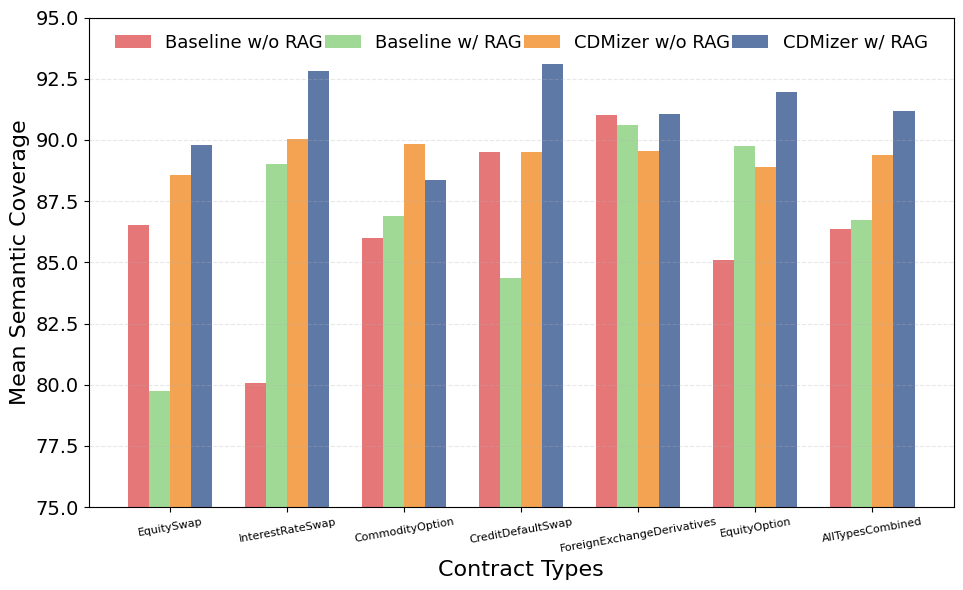

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Keep your original colors
# colors = ["#E15759", "#76B7B2", "#F28E2B", "#4E79A7"]
colors = ["#E46869", "#96D58A", "#F39940", "#4E6B9C"]


contract_types = list(summary_stats.keys())

display_labels = {
    "InterestRate": "InterestRateSwap",
    "Commodity": "CommodityOption",
    "ForeignExchange": "ForeignExchangeDerivatives"
}

print(contract_types)

xtick_labels = [display_labels.get(c, c) for c in contract_types]

# Extract means
means_summary = [summary_stats[c]['mean'] for c in contract_types]
means_summary_rag = [summary_stats_rag[c]['mean'] for c in contract_types]
means_summary_2 = [summary_stats_2[c]['mean'] for c in contract_types]
means_summary_rag_2 = [summary_stats_rag_2[c]['mean'] for c in contract_types]

# Extract standard deviations (SD)
sd_summary = [summary_stats[c]['sd'] for c in contract_types]
sd_summary_rag = [summary_stats_rag[c]['sd'] for c in contract_types]
sd_summary_2 = [summary_stats_2[c]['sd'] for c in contract_types]
sd_summary_rag_2 = [summary_stats_rag_2[c]['sd'] for c in contract_types]

x = np.arange(len(contract_types))
width = 0.18

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with SD error bars (matching colors, subtle caps)
# ax.bar(x - 1.5*width, means_summary_2, width, yerr=sd_summary_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/o RAG", color=colors[0], alpha=0.9)
# ax.bar(x - 0.5*width, means_summary_rag_2, width, yerr=sd_summary_rag_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/ RAG", color=colors[1], alpha=0.9)
# ax.bar(x + 0.5*width, means_summary, width, yerr=sd_summary, capsize=2, error_kw=dict(lw=0.6, capthick=0.6), label="CDMizer w/o RAG", color=colors[2], alpha=0.9)
# ax.bar(x + 1.5*width, means_summary_rag, width, yerr=sd_summary_rag, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="CDMizer w/ RAG", color=colors[3], alpha=0.9)


ax.bar(x - 1.5*width, means_summary_2, width, label="Baseline w/o RAG", color=colors[0], alpha=0.9)
ax.bar(x - 0.5*width, means_summary_rag_2, width, label="Baseline w/ RAG", color=colors[1], alpha=0.9)
ax.bar(x + 0.5*width, means_summary, width, label="CDMizer w/o RAG", color=colors[2], alpha=0.9)
ax.bar(x + 1.5*width, means_summary_rag, width, label="CDMizer w/ RAG", color=colors[3], alpha=0.9)



# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=10, fontsize=8)

# Labels & Formatting (unchanged from your original)
ax.set_ylabel("Mean Semantic Coverage", fontsize=16)
ax.set_xlabel("Contract Types", fontsize=16)
ax.set_ylim(75, 95)
ax.tick_params(axis="y", labelsize=14)

# Legend (exact same position & format as yours)
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=4, fontsize=13, handletextpad=0.4, columnspacing=0.1, frameon=False)

# Light gridlines for readability
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Keep layout tight for a clean look
plt.tight_layout()
plt.show()


In [9]:
import os
import json
import statistics

def compute_scores(test_contracts, generated_cdm_parent_folder, generated_cdm_folder, cdm_schema_path, cdm_repo_path):
    scores, scores_rag = {}, {}
    scores_schem, scores_schem_rag = {}, {}

    for contract_type, contracts in test_contracts.items():
        scores.setdefault(contract_type, [])  # Ensure lists, not dicts
        scores_rag.setdefault(contract_type, [])
        scores_schem.setdefault(contract_type, [])
        scores_schem_rag.setdefault(contract_type, [])

        for contract in contracts:
            for mode, store_syn, store_schem in [
                ("without_rag", scores[contract_type], scores_schem[contract_type]),
                ("with_rag", scores_rag[contract_type], scores_schem_rag[contract_type])
            ]:
                path = os.path.join(generated_cdm_parent_folder, generated_cdm_folder, mode, contract_type, contract["id"])
                
                if os.path.exists(path):
                    with open(path) as f:
                        cdm = json.load(f)
                        syntactic_correctness, schema_adherence = evaluate_cdm(cdm, cdm_schema_path, cdm_repo_path)
                        store_syn.append(syntactic_correctness['correct_percentage'])
                        store_schem.append(schema_adherence)
                else:
                    print(f"!!! ({mode.upper()}) eval results do not exist: {path}")

    # Function to safely compute stats, avoiding empty list errors
    def safe_stats(values):
        if not values:  # If list is empty, return None for all stats
            return {"min": None, "max": None, "mean": None, "median": None, "sd": None}
        return {
            "min": min(values),
            "max": max(values),
            "mean": sum(values) / len(values),
            "median": statistics.median(values),
            "sd": statistics.stdev(values) if len(values) > 1 else 0  # SD requires at least two values
        }

    return {
        "syntactic_correctness": {key: safe_stats(values) for key, values in scores.items()},
        "syntactic_correctness_rag": {key: safe_stats(values) for key, values in scores_rag.items()},
        "schema_adherence": {key: safe_stats(values) for key, values in scores_schem.items()},
        "schema_adherence_rag": {key: safe_stats(values) for key, values in scores_schem_rag.items()},
    }

test_contracts = load_test_contracts(test_data_dir)

cdm_schema_path = "../cdm_schema/"
cdm_repo_path = "../cdm_schema/cdm_schema_json"
generated_cdm_parent_folder = "direct_cdm_generation/test_results_cdm"

scores = compute_scores(test_contracts, generated_cdm_parent_folder, generated_cdm_folder, cdm_schema_path, cdm_repo_path)

print(scores)


!!! (WITH_RAG) eval results do not exist: direct_cdm_generation/test_results_cdm/Meta-Llama-3.1-8B-Instruct/with_rag/CreditDefaultSwap/FpML_cd_37.json
{'syntactic_correctness': {'EquitySwap': {'min': 18.421052631578945, 'max': 83.33333333333334, 'mean': 54.990451455198226, 'median': 60.37735849056604, 'sd': 24.413511862301544}, 'InterestRate': {'min': 9.230769230769232, 'max': 73.01587301587301, 'mean': 46.80074087870698, 'median': 58.333333333333336, 'sd': 28.009470913628572}, 'Commodity': {'min': 51.02040816326531, 'max': 76.74418604651163, 'mean': 60.540248432973826, 'median': 53.48837209302325, 'sd': 11.279050062464927}, 'CreditDefaultSwap': {'min': 51.92307692307693, 'max': 79.76190476190477, 'mean': 63.81788259070207, 'median': 59.61538461538461, 'sd': 10.779621285923415}, 'ForeignExchange': {'min': 53.84615384615385, 'max': 74.4186046511628, 'mean': 64.6127084850209, 'median': 64.15094339622641, 'sd': 7.518869649073813}, 'EquityOption': {'min': 41.46341463414634, 'max': 80.76923